In [1]:
# setting path for mv_python_utils
sys.path.append('../helper_functions')
# import custom funciton for loading MATLAB structures
from mv_python_utils import loadmat_struct


In [2]:
# define input folder
infold = '/remotedata/AgGross/TBraiC/MV-eye/STRG_computed_features/Mdl_comparison/'


In [3]:
# import data (and lib needed)
import numpy as np
import pandas as pd

nsubjs = 29
pre_mat = np.empty((52, 41, 4, nsubjs))

for isubj in range(nsubjs):
    
    subjcode = f'{isubj+1:02d}'
    
    condlabel_accumulator = -1;
    for icond in ['ECEO', 'VS']:
        
        fname = infold + subjcode + '_' + icond + '_TimeFeats.mat'
        mat_content = loadmat_struct(fname)
        F = mat_content['variableName']
        cond_labels = F['Y']
        single_parcels = F['single_parcels']
        single_feats = F['single_feats']
        
        acc_parcel = 0
        for feat_array in single_parcels:
    
            for ilabel in [1, 2]:
            
                this_cond = np.mean(feat_array[cond_labels==ilabel, :], axis=0)
                pre_mat[acc_parcel, :, condlabel_accumulator+ilabel, isubj] = this_cond
                
            acc_parcel+=1
    
        condlabel_accumulator += 2


In [4]:
# preprocess data: robust scale it and tanh
from sklearn.preprocessing import RobustScaler

preprocessed_dat = np.empty(pre_mat.shape)

# robust scaling performed on each parcel/feature, across all subjs and conds
for iparcel in range(52):
    
    for ifeat in range(41):
        
        x_ = pre_mat[iparcel, ifeat, :, :]
        expanded_ = np.expand_dims(x_.flatten(), axis=1)
        transformed = RobustScaler().fit_transform(expanded_)
        post_ = np.reshape(transformed[:, 0], x_.shape)
        preprocessed_dat[iparcel, ifeat, :, :] = np.tanh(post_)

        

In [16]:
# save data into MATLAB
from scipy.io import savemat

savemat('avg_preproc.mat', {'dat': preprocessed_dat})



(array([18034., 22330., 27883., 26910., 28494., 27498., 25742., 26725.,
        23452., 20244.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

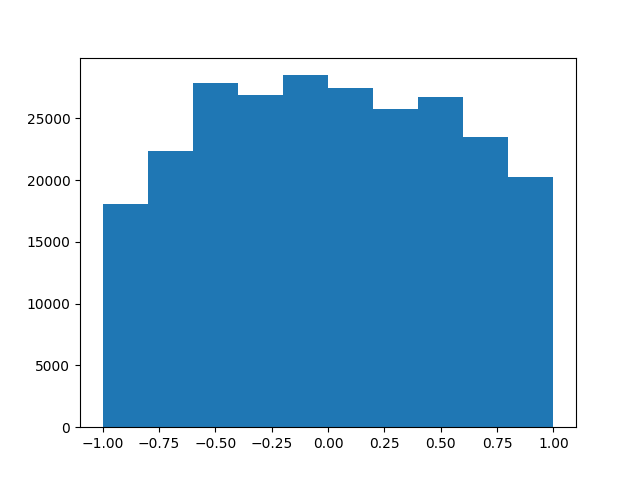

In [5]:
# visualize distribution of ptreprocessed data
%matplotlib ipympl
import matplotlib.pyplot as plt

plt.figure()
plt.hist(preprocessed_dat.flatten())


In [11]:
# finally, try dPCA
from dPCA import dPCA
dpca = dPCA.dPCA(labels='fcs', n_components=15)

# apply transformation
mdl = dpca.fit(preprocessed_dat)



In [15]:
mdl.compute_mean_score()

AttributeError: 'dPCA' object has no attribute 'compute_mean_score'

In [ ]:
# show comps in 3d space
conds = Z['c']
avg_subjs = conds.mean(axis=-1)

cond_labels = ['EC', 'EO', 'bsl', 'VS']

ax = plt.figure().add_subplot(projection='3d')
for icond in range(4):
    
    this_cond = avg_subjs[:, :, icond]
    ax.scatter(this_cond[0, :], this_cond[1, :], this_cond[2, :], label=cond_labels[icond])
    
plt.legend()


In [ ]:
# show comps in 3d space
feats = Z['f']
avg_subjs = feats.mean(axis=-1)

# cond_labels = ['EC', 'EO', 'bsl', 'VS']

import itertools
colors = itertools.cycle(["r", "b", "g", "k"])

ax = plt.figure().add_subplot(projection='3d')
for ifeat in range(41):
    
    this_cond = avg_subjs[:, ifeat, :]
    ax.scatter(this_cond[0, :], this_cond[1, :], this_cond[2, :], color=next(colors))
